### CONFIGURACAO AMBIENTE

In [1]:
# Importar as bibliotecas necessárias
import pandas as pd
import numpy as np
import os
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sqlalchemy import create_engine

# Configurações do banco de dados
DB_NAME = "vitivinicultura_db"
DB_USER = "postgres"
DB_PASSWORD = "102030"
DB_HOST = "localhost"
DB_PORT = "5432"

# Criar o engine de conexão usando SQLAlchemy
connection_string = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(connection_string)

# Criar uma conexão a partir do engine
connection = engine.raw_connection()


### DATA LOAD

In [2]:
# Carregar os dados da tabela de exportação
query = "SELECT * FROM exportacao;"
df_exportacao = pd.read_sql(query, con=connection)

# Fechar a conexão
connection.close()

# Visualizar os primeiros registros dos dados carregados
df_exportacao.head()


/tmp/ipykernel_370747/2683005586.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_exportacao = pd.read_sql(query, con=connection)


,id,ano,pais,quantidade_litros,valor_usd,data_insercao
0,1,2023,Afeganistão,NaN,NaN,2025-03-30 18:27:41.917881
1,2,2023,África do Sul,117.0,698.0,2025-03-30 18:27:41.917881
2,3,2023,"Alemanha, República Democrática",4806.0,31853.0,2025-03-30 18:27:41.917881
3,4,2023,Angola,NaN,NaN,2025-03-30 18:27:41.917881
4,5,2023,Anguilla,NaN,NaN,2025-03-30 18:27:41.917881


### DATA PREPARATION

In [3]:
# Substituir "-" por NaN nas colunas 'quantidade_litros' e 'valor_usd'
df_exportacao['quantidade_litros'] = pd.to_numeric(df_exportacao['quantidade_litros'], errors='coerce')
df_exportacao['valor_usd'] = pd.to_numeric(df_exportacao['valor_usd'], errors='coerce')

# Remover linhas com valores ausentes (NaN) em 'quantidade_litros' ou 'valor_usd'
df_clean = df_exportacao.dropna(subset=['quantidade_litros', 'valor_usd'])

# Verificar se há mais dados ausentes após limpeza
df_clean.isnull().sum()

id                   0
ano                  0
pais                 0
quantidade_litros    0
valor_usd            0
data_insercao        0
dtype: int64

Correlação entre quantidade_litros e valor_usd: 0.97


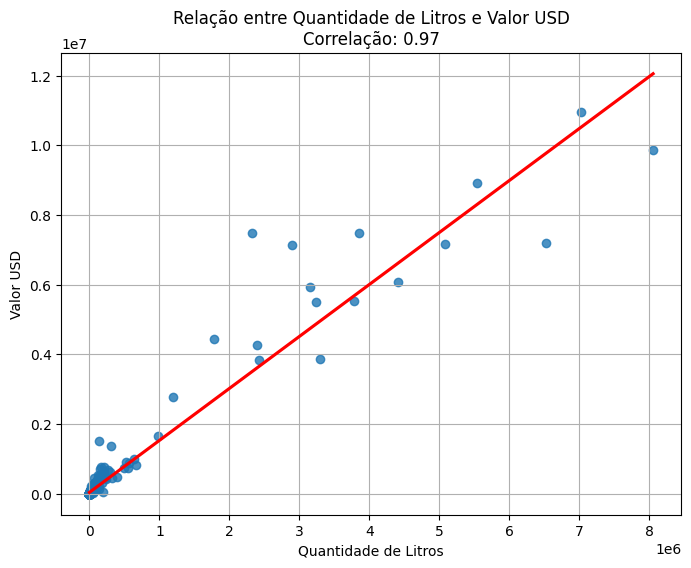

In [4]:
# Calcular a correlação
correlacao = df_clean[['quantidade_litros', 'valor_usd']].corr().iloc[0, 1]
print(f"Correlação entre quantidade_litros e valor_usd: {correlacao:.2f}")

# Scatter plot com linha de tendência
plt.figure(figsize=(8, 6))
sns.regplot(data=df_clean, x='quantidade_litros', y='valor_usd', ci=None, line_kws={"color": "red"})
plt.title(f"Relação entre Quantidade de Litros e Valor USD\nCorrelação: {correlacao:.2f}")
plt.xlabel("Quantidade de Litros")
plt.ylabel("Valor USD")
plt.grid()
plt.show()

#### GERAR DADOS SINTETICOS E ADICIONAR RUIDOS

In [5]:
# Gerar dados sintéticos a partir do dataframe original
def gerar_dados_sinteticos(df_original, num_novos_dados):
    # Inicializar uma lista para armazenar os novos dados
    dados_sinteticos = []

    for _ in range(num_novos_dados):
        # Seleciona um registro aleatório do dataframe original
        sample = df_original.sample(n=1, random_state=np.random.randint(0, 10000))

        # Adiciona ruído nas variáveis 'quantidade_litros' e 'valor_usd'
        ruido_quantidade = np.random.normal(loc=0, scale=sample['quantidade_litros'].values[0] * 0.1)
        ruido_valor = np.random.normal(loc=0, scale=sample['valor_usd'].values[0] * 0.1)

        # Cria uma nova amostra com o ruído
        novo_dado = {
            'ano': sample['ano'].values[0],
            'pais': sample['pais'].values[0],
            'quantidade_litros': sample['quantidade_litros'].values[0] + ruido_quantidade,
            'valor_usd': sample['valor_usd'].values[0] + ruido_valor
        }

        # Adiciona a nova amostra à lista de dados sintéticos
        dados_sinteticos.append(novo_dado)

    # Converter a lista de dados sintéticos para um DataFrame
    df_sintetico = pd.DataFrame(dados_sinteticos)

    return df_sintetico

# Gerar 1000 novos registros sintéticos
df_novos_dados = gerar_dados_sinteticos(df_clean, 1000)

# Concatenar os dados reais com os dados sintéticos
df_clean = pd.concat([df_clean, df_novos_dados], ignore_index=True)

# Verificar o DataFrame final
df_clean.head()


,id,ano,pais,quantidade_litros,valor_usd,data_insercao
0,2.0,2023,África do Sul,117.0,698.0,2025-03-30 18:27:41.917881
1,3.0,2023,"Alemanha, República Democrática",4806.0,31853.0,2025-03-30 18:27:41.917881
2,6.0,2023,Antígua e Barbuda,383.0,1848.0,2025-03-30 18:27:41.917881
3,8.0,2023,Arábia Saudita,124.0,142.0,2025-03-30 18:27:41.917881
4,9.0,2023,Argentina,4545.0,36133.0,2025-03-30 18:27:41.917881


Correlação entre quantidade_litros e valor_usd: 0.96


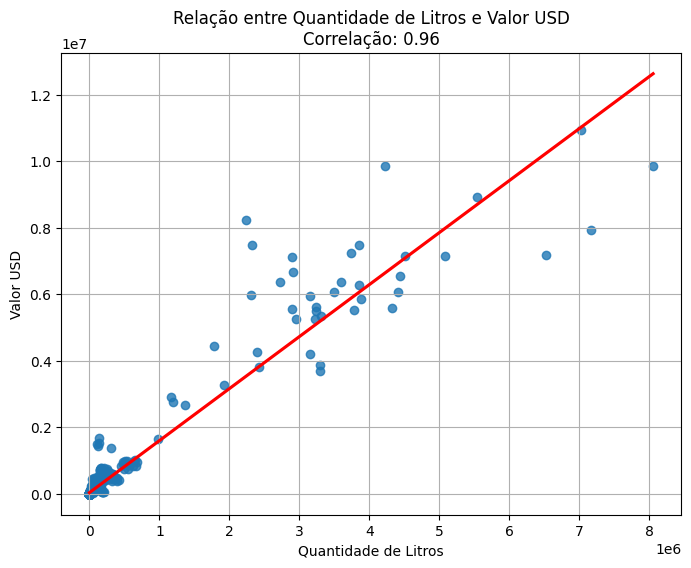

In [6]:
# Calcular a correlação
correlacao = df_clean[['quantidade_litros', 'valor_usd']].corr().iloc[0, 1]
print(f"Correlação entre quantidade_litros e valor_usd: {correlacao:.2f}")

# Scatter plot com linha de tendência
plt.figure(figsize=(8, 6))
sns.regplot(data=df_clean, x='quantidade_litros', y='valor_usd', ci=None, line_kws={"color": "red"})
plt.title(f"Relação entre Quantidade de Litros e Valor USD\nCorrelação: {correlacao:.2f}")
plt.xlabel("Quantidade de Litros")
plt.ylabel("Valor USD")
plt.grid()
plt.show()

In [7]:
# Codificar os países usando OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Codificar a coluna 'pais'
pais_encoded = encoder.fit_transform(df_clean[['pais']])

# Criar um DataFrame com as variáveis codificadas
pais_encoded_df = pd.DataFrame(pais_encoded, columns=encoder.get_feature_names_out(['pais']))

# Concatenar as variáveis codificadas com os dados numéricos
df_encoded = pd.concat([df_clean[['ano', 'quantidade_litros', 'valor_usd']], pais_encoded_df], axis=1)

# Exibir as primeiras linhas do DataFrame codificado
df_encoded.head()

,ano,quantidade_litros,valor_usd,pais_Afeganistão,"pais_Alemanha, República Democrática",pais_Angola,pais_Antilhas Holandesas,pais_Antígua e Barbuda,pais_Argentina,pais_Aruba,...,pais_Total,pais_Trinidade Tobago,pais_Turquia,pais_Tuvalu,pais_Uruguai,pais_Vanuatu,pais_Venezuela,pais_Vietnã,pais_África do Sul,pais_Áustria
0,2023,117.0,698.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2023,4806.0,31853.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023,383.0,1848.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023,124.0,142.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023,4545.0,36133.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
print(df_encoded.columns)

Index(['ano', 'quantidade_litros', 'valor_usd', 'pais_Afeganistão',
       'pais_Alemanha, República Democrática', 'pais_Angola',
       'pais_Antilhas Holandesas', 'pais_Antígua e Barbuda', 'pais_Argentina',
       'pais_Aruba',
       ...
       'pais_Total', 'pais_Trinidade Tobago', 'pais_Turquia', 'pais_Tuvalu',
       'pais_Uruguai', 'pais_Vanuatu', 'pais_Venezuela', 'pais_Vietnã',
       'pais_África do Sul', 'pais_Áustria'],
      dtype='object', length=124)


In [9]:
# Definir as variáveis de entrada (X) e as variáveis de saída (y)
X = df_encoded.drop(columns=['quantidade_litros', 'valor_usd'])  # Remover as colunas de saída
y = df_encoded[['quantidade_litros', 'valor_usd']]  # Colunas de saída

#y = df_encoded['valor_usd'] # Colunas de saída


In [10]:

# Dividir os dados em conjunto de treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Preencher valores NaN com a média das colunas
X_train = X_train.fillna(X_train.mean())
y_train = y_train.fillna(y_train.mean())
X_test = X_test.fillna(X_test.mean())
y_test = y_test.fillna(y_test.mean())


# Exibir as dimensões dos conjuntos de treino e teste
print(f"Dimensões do conjunto de treino X: {X_train.shape}")
print(f"Dimensões do conjunto de teste X: {X_test.shape}")
print(f"Dimensões do conjunto de treino y: {y_train.shape}")
print(f"Dimensões do conjunto de teste y: {y_test.shape}")


Dimensões do conjunto de treino X: (1252, 122)
Dimensões do conjunto de teste X: (313, 122)
Dimensões do conjunto de treino y: (1252, 2)
Dimensões do conjunto de teste y: (313, 2)


## MODEL TRAINING

#### TRAINING (LINEAR REGRESSION)

In [11]:
# Criar o modelo de Regressão Linear
model = LinearRegression()

# Treinar o modelo com os dados de treino
model.fit(X_train, y_train)

# Exibir os coeficientes do modelo treinado
print(f"Coeficientes do modelo: {model.coef_}")

Coeficientes do modelo: [[ 2.68383604e+04 -9.58199850e+04 -4.78478588e+04  2.78549286e+04
   5.71592205e+04 -7.48214860e+04 -5.93757622e+04  9.24688290e+04
  -1.49383824e+05 -1.88306958e+04 -7.88189292e+04 -1.06561040e+05
  -1.15855189e+05 -1.02600841e+05 -4.21453826e+04  1.46383804e+04
  -1.49492583e+05 -4.24787627e+04 -1.07974861e+05 -1.22664593e+05
  -1.03777152e+04 -6.89497359e+04 -6.89767770e+04 -7.21772624e+03
  -2.39874187e+03 -1.00310999e+05 -7.96079645e+04 -9.09923995e+04
   3.22311967e+04 -7.16732990e+04  1.30890310e+04 -1.22643395e+05
  -6.31313553e+04 -6.89839383e+04 -1.33878012e+05 -8.23438939e+04
  -1.15928191e+05  6.05959557e+04 -5.88623268e+04 -3.09065906e+04
  -1.08309080e+05 -2.49293677e+04 -8.99445082e+04 -6.30303012e+04
   2.01611937e+05  3.92606985e+04 -7.54197218e+04  6.00217781e+04
  -1.76399214e+04 -5.63585986e+04 -5.51782328e+04 -1.17121236e+05
  -9.44630652e+04 -1.02461730e+05 -8.30120652e+04 -1.15920972e+05
   1.15676992e+04  8.87310133e+03  2.66807975e+05 -3

#### EVALUATE MODEL

In [12]:
# Fazer previsões com os dados de teste
y_pred = model.predict(X_test)

# Calcular o erro quadrático médio (MSE)
mse = mean_squared_error(y_test, y_pred)

# Exibir o MSE
print(f"Erro Quadrático Médio (MSE): {mse}")

Erro Quadrático Médio (MSE): 84396949877.61539


### PREDICT

In [13]:
# Exemplo de previsão para o ano de 2024 e país "Brasil"
novo_ano = 2025
novo_pais = 'Brasil'

# Criar um DataFrame com o ano e a codificação do país
novo_pais_encoded = encoder.transform([[novo_pais]])
entrada = pd.DataFrame([list([novo_ano]) + list(novo_pais_encoded[0])], columns=X.columns)

# Fazer a previsão de quantidade de litros e valor em USD para o novo país e ano
quantidade_prevista, valor_previsto = model.predict(entrada)[0]

# Exibir os resultados da previsão
print(f"Previsão para o {novo_pais} em {novo_ano}:")
print(f"Quantidade de Litros: {quantidade_prevista}")
print(f"Valor em USD: {valor_previsto}")


Previsão para o Brasil em 2025:
Quantidade de Litros: 95209.68354953825
Valor em USD: 95299.18951192498


/home/alberone/projects/fiap/ml-engineering/ml-tech-fiap-vitivinicultura-api/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


### SAVE MODEL

In [ ]:

# Caminho relativo à raiz do projeto
root_dir = os.path.dirname(os.path.abspath(__file__))  # Diretório raiz do projeto
save_dir = os.path.join(root_dir, 'ml-model', 'production')

# Certifique-se de que o diretório existe, caso contrário, crie-o
os.makedirs(save_dir, exist_ok=True)

# Caminhos completos para os arquivos
model_path = os.path.join(save_dir, 'modelo_exportacao.pkl')
encoder_path = os.path.join(save_dir, 'encoder_exportacao.pkl')

# Salvar o modelo treinado e o encoder
joblib.dump(model, model_path)
joblib.dump(encoder, encoder_path)

print(f"Modelo salvo em: {model_path}")
print(f"Encoder salvo em: {encoder_path}")

['encoder_exportacao.pkl']